# Latent Variable Models and Variational Bayes


### Preliminaries

- Goal 
  - Introduction to latent variable models and variational inference by Free energy minimization   
- Materials
  - Mandatory
    - These lecture notes
  - Optional 
    - Bishop (2016), pp. 461-486 (sections 10.1, 10.2 and 10.3) 
    - Ariel Caticha (2010), [Entropic Inference](https://arxiv.org/abs/1011.0723)
      - tutorial on entropic inference, which is a generalization to Bayes rule and provides a foundation for variational inference.
  - references <a id='references'></a>
    - Blei et al. (2017), [Variational Inference: A Review for Statisticians](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773) 
    - Lanczos (1961), [The variational principles of mechanics](https://www.amazon.com/Variational-Principles-Mechanics-Dover-Physics/dp/0486650677)
    - Senoz et al. (2021), [Variational Message Passing and Local Constraint Manipulation in Factor Graphs](https://www.mdpi.com/1099-4300/23/7/807)
    - Dauwels (2007), [On variational message passing on factor graphs](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Dauwels-2007-on-variational-message-passing-on-factor-graphs)
    - Shore and Johnson (1980), [Axiomatic Derivation of the Principle of Maximum Entropy and the Principle of Minimum Cross-Entropy](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/ShoreJohnson-1980-Axiomatic-Derivation-of-the-Principle-of-Maximum-Entropy.pdf)
    

### Illustrative Example <a id="illustrative-example"></a>: Density Modeling for the Old Faithful Data Set

- You're now asked to build a density model for a data set ([Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful), Bishop pg. 681) that clearly is not distributed as a single Gaussian:

<p style="text-align:center;"><img src="./figures/fig-Bishop-A5-Old-Faithfull.png" width="500"></p>

###  Unobserved Classes

Consider again a set of observed data $D=\{x_1,\dotsc,x_N\}$

- This time we suspect that there are _unobserved_ class labels that would help explain (or predict) the data, e.g.,
  - the observed data are the color of living things; the unobserved classes are animals and plants.
  - observed are wheel sizes; unobserved categories are trucks and personal cars.
  - observed is an audio signal; unobserved classes include speech, music, traffic noise, etc.
 

   
- Classification problems with unobserved classes are called **Clustering** problems. The learning algorithm needs to **discover the classes from the observed data**.

### The Gaussian Mixture Model

- The spread of the data in the illustrative example looks like it could be modeled by two Gaussians. Let's develop a model for this data set. 

- Let $D=\{x_n\}$ be a set of observations. We associate a one-hot coded hidden class label $z_n$ with each observation:

$$\begin{equation*}
z_{nk} = \begin{cases} 1 & \text{if } x_n \in \mathcal{C}_k \text{ (the k-th class)}\\
                       0 & \text{otherwise} \end{cases}
\end{equation*}$$

- We consider the same model as we did in the [generative classification lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Generative-Classification.ipynb#GDA):
$$\begin{align*}
p(x_n | z_{nk}=1) &= \mathcal{N}\left( x_n | \mu_k, \Sigma_k\right)\\
p(z_{nk}=1) &= \pi_k
\end{align*}$$
which can be summarized with the selection variables $z_{nk}$ as
$$\begin{align*}
p(x_n,z_n) &= p(x_n | z_n) p(z_n) = \prod_{k=1}^K (\underbrace{\pi_k \cdot \mathcal{N}\left( x_n | \mu_k, \Sigma_k\right) }_{p(x_n,z_{nk}=1)})^{z_{nk}} 
\end{align*}$$

- *Again*, this is the same model  as we defined for the generative classification model: A Gaussian-Categorical model but now with unobserved classes. 

- This model (with **unobserved class labels**) is known as a **Gaussian Mixture Model** (GMM).

### The Marginal Distribution for the GMM

- In the literature, the GMM is often introduced by the marginal distribution for an _observed_ data point $x_n$, given by

$$\begin{align*}{}
p(x_n) &= \sum_{z_n} p(x_n,z_n)  \\
  &= \sum_{k=1}^K \pi_k \cdot \mathcal{N}\left( x_n | \mu_k, \Sigma_k \right) \tag{B-9.12}
\end{align*}$$

- Full proof as an [exercise](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/exercises/Exercises-Latent-Variable-Models-and-VB.ipynb). 

- Eq. B-9.12 reveals the link to the name Gaussian *mixture model*. The priors $\pi_k$ are also called **mixture coefficients**. 

- Be aware that Eq. B-9.12 is not the generative model for the GMM! The generative model is the joint distribution $p(x,z)$ over all variables, including the latent variables. 
  
 

###  GMM is a very flexible model

- GMMs are very popular models. They have decent computational properties and are **universal approximators of densities** (as long as there are enough Gaussians of course)

<p style="text-align:center;"><img src="./figures/fig-ZoubinG-GMM-universal-approximation.png" width="600"></p>

- (In the above figure, the Gaussian components are shown in <font color=red>red</font> and the pdf of the mixture models in <font color=blue>blue</font>).

### Latent Variable Models

- The GMM contains both _observed_ variables $ \{x_n\}$, (unobserved) _parameters_ $\theta= \{\pi_k,\mu_k, \Sigma_k\}$ _and_ unobserved (synonym: latent, hidden) variables $\{z_{nk}\}$.

- From a Bayesian viewpoint, both latent variables $\{z_{nk}\}$ and parameters $\theta$ are just unobserved variables for which we can set a prior and compute a posterior by Bayes rule. 

- Note that $z_{nk}$ has a subscript $n$, hence its value depends not only on the cluster ($k$) but also on the $n$-th observation (in contrast to parameters). These observation-dependent latent variables are generally a useful tool to encode additional structure in the model about the causes of your observations. Here (in the GMM), the latent variables $\{z_{nk}\}$ encode (unobserved) class membership. 

- By adding model structure through (equations among) latent variables, we can build more accurate models for very complex processes. Unfortunately, adding structure through latent variables in models often is accompanied by a more complex inference task.

### Inference for GMM is Difficult

- Indeed, the fact that the class labels are _unobserved_ for the GMM, leads to a problem for processing new data by Bayes rule in a GMM.

- Consider a given data set $D = \{x_n\}$. We recall here the log-likelihood for the Gaussian-Categorial Model, see the [generative classification lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Generative-Classification.ipynb):

$$
\log\, p(D|\theta) =  \sum_{n,k} y_{nk} \underbrace{ \log\mathcal{N}(x_n|\mu_k,\Sigma) }_{ \text{Gaussian} } + \underbrace{ \sum_{n,k} y_{nk} \log \pi_k }_{ \text{multinomial} } \,.
$$

- Since the class labels $y_{nk} \in \{0,1\}$ were assumed to be given by the data set, maximization of this expression decomposed into a set of simple update rules for the Gaussian and multinomial distributions. 

- However, for the Gaussian mixture model (same log-likelihood function with $z_{nk}$ replacing $y_{nk}$), the class labels $\{z_{nk}\}$ are _unobserved_ and they need to be estimated alongside with the parameters.

- There is no known conjugate prior for the latent variables for the GMM likelihood function and, therefore, we cannot compute Bayes rule to get a closed-form expression for the posterior over the latent variables:
$$ \underbrace{p(\{z_{nk}\},\{\mu_k,\Sigma_k,\pi_k\} | D)}_{\text{posterior (no analytical solution)}} \propto \underbrace{p(D\,|\,\{z_{nk}\},\{\mu_k,\Sigma_k,\pi_k\})}_{\text{likelihood}} \cdot \underbrace{p( \{z_{nk}\},\{\mu_k,\Sigma_k,\pi_k\} )}_{\text{prior (no known conjugate)}} $$

- Can we still compute an approximate posterior? In this lesson, we introduce an approximate Bayesian inference method known as **Variational Bayes** (VB) (also known as **Variational Inference**) that can be used for Bayesian inference in models with latent variables. Later in this lesson, we will use VB to do inference in the GMM.   

 ### The Variational Free Energy Functional

 - We'll start from scratch. Consider a model $p(x,z) = p(x|z) p(z)$, where $x$ and $z$ are observed and latent variables respectively. $z$ may include parameters but also observation-dependent latent variables. 

 - The goal of Bayesian inference is to transform the (known) _likelihood-times-prior_ factorization of the full model to a _posterior-times-evidence_ decomposition: 
 $$ \underbrace{p(x|z) p(z)}_{\text{what we know}} \rightarrow \underbrace{p(z|x) p(x)}_{\text{what we want}} $$

 - Remember from the [Bayesian machine learning lesson](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Bayesian-Machine-Learning.ipynb#Bayesian-model-evidence) that negative log-evidence can be decomposed as "complexity" minus "accuracy" terms (the CA decomposition):
 $$
 -\log p(x) =  \underbrace{ \int p(z|x) \log \frac{p(z|x)}{p(z)} \mathrm{d}z }_{\text{complexity}} - \underbrace{\int p(z|x) \log p(x|z) \mathrm{d}z}_{\text{accuracy}}
 $$

 - The CA decomposition cannot be evaluated because it depends on the posterior $p(z|x)$, which cannot be evaluated since it is the objective of the inference process. 

 - Let's now introduce a distribution $q(z)$ that we use to approximate the posterior $p(z|x)$, and assume that $q(z)$ can be evaluated! 
 
 - If will substitute $q(z)$ for $p(z|x)$ in the CA decomposition, then we obtain 
 $$
 F[q] \triangleq  \underbrace{ \int q(z) \log \frac{q(z)}{p(z)} \mathrm{d}z }_{\text{complexity}} - \underbrace{\int q(z) \log p(x|z) \mathrm{d}z}_{\text{accuracy}}
 $$

 - This expression is called the variational _Free Energy_ (FE). We consider the Free Energy $F$ as a function of the posterior $q(z)$. Technically, a function of a function is called a functional, and we write square brackets (e.g., $F[q]$) to differentiate functionals from functions (e.g., $q(z)$).
 
 - Note that all factors in the CA decomposition of FE (i.e., $q(z)$, $p(z)$ and $p(x|z)$) can be evaluated and therefore the FE can be evaluated. This is important: log-evidence cannot be evaluated, but FE _can_ be evaluated! 


### Inference by FE Minimization

- It turns out that we can do (approximate) Bayesian inference through FE Minimization (FEM) with respect to $q$. 

- To explain inference by FEM, we first rewrite FE in terms of "inference bound" minus "log-evidence" terms (the bound-evidence (BE) decomposition):
$$\begin{align*}
 F[q] &= \underbrace{ \int q(z) \log \frac{q(z)}{p(z)} \mathrm{d}z }_{\text{complexity}} - \underbrace{\int q(z) \log p(x|z) \mathrm{d}z}_{\text{accuracy}} \\
 &= \int q(z) \log \frac{q(z)}{p(z) p(x|z) }\mathrm{d}z \\
 &= \int q(z) \log \frac{q(z)}{p(z|x) p(x)}\mathrm{d}z \\
 &= \underbrace{\int q(z) \log \frac{q(z)}{p(z|x)}\mathrm{d}z}_{\text{inference bound}\geq 0} - \underbrace{\log p(x)}_{\text{log-evidence}} 
 \end{align*}$$

- Note that the inference bound is a [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between an (approximate) posterior $q(z)$ and the (perfect) Bayesian posterior $p(z|x)$. See this [slide in the BML Class](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Bayesian-Machine-Learning.ipynb#KLD) for more info on the KL divergence. 

- Since the second term (log-evidence) does not involve $q(z)$, FEM over $q$ will bring $q(z)$ closer to the Bayesian posterior $p(z|x)$.

- Since $\mathrm{KL}[q(z),p(z|x)]\geq 0$ for any $q(z)$, and $\mathrm{KL}[q(z),p(z|x)]= 0$  only if $q(z)=p(z|x)$, the FE is always an upperbound on (minus) log-evidence, i.e.,
$$
F[q] \geq -\log p(x) \,.
$$

- As a result, **global FEM recovers Bayes rule**, i.e., global optimization of FE w.r.t. $q$ leads to
$$q^*(z) = \arg\min_q F[q]$$
where
$$\begin{align*}
   \text{posterior: } q^*(z) &= p(z|x) \\
   \text{evidence: } F[q^*] &= -\log p(x) 
\end{align*}$$

- In practice, even if we cannot attain the global minimum of FE, we can still use a local minimum $$\hat{q}(z) \approx \arg\min_q F[q]$$ to accomplish **approximate Bayesian inference** by: 
$$\begin{align*}
   \text{posterior: } \hat{q}(z) &\approx p(z|x) \\
   \text{evidence: } F[\hat{q}] &\approx -\log p(x)
    \end{align*}$$

- FE minimization transforms an inference problem (that involves integration) to an optimization problem! Generally, optimization problems are easier to solve than integration problems. 

- Executing inference by minimizing the variational FE functional is called **Variational Bayes** (VB) or variational inference. 

-  (As an aside), note that Bishop introduces in Eq. B-10.2 an _Evidence Lower BOund_ (in modern machine learning literature abbreviated as **ELBO**) $\mathcal{L}(z)$ that equals the _negative_ FE. In this class, we prefer to discuss inference in terms of minimizing Free Energy rather than maximizing ELBO, but note that these two concepts are equivalent. (The reason why we prefer the Free Energy formulation relates to the terminology in the Free Energy Principle, which we introduce in the [Intelligent Agents and active Inference lesson (B12)](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb)). 



### Constrained FE Minimization 

- Generally, it is common to add constraints to optimization problems to make a difficult optimization task tractible. This is also common practice when approximating Bayesian inference by FE minimization.

- There are three important cases of adding constraints to $q(z)$ that often alleviates the FE minimization task:
   1. #### mean-field factorization
     - In mean-field factorization, we constrain the posterior to factorize into a set of _independent_ factors, i.e., 
     $$
        q(z) = \prod_{j=1}^m q_j(z_j)\,, \tag{B-10.5}
     $$ 
     - Variational inference with mean-field factorization has been worked out in detail as the **Coordinate Ascent Variational Inference** (CAVI) algorithm. See the [Optional Slide on CAVI](#CAVI) for details. 
     - Mean-field factorization is just an example of various _factorization constraints_ that have been successfully applied to FEM. 

   2. #### form constraints
     - We constrain the posterior to be part of a parameterized probability distribution, e.g., $$q(z) = \mathcal{N}\left( z | \mu, \Sigma \right)\,.$$ 
     - In this case, the functional minimization problem for $F[q]$ reduces to the minimization of a _function_ $F(\mu,\Sigma)$ w.r.t. its parameters. We can often use standand gradient-based optimization methods to minimize the FE.   
     - The following image by [David Blei](https://www.cs.columbia.edu/~blei/) illustrates this approach:
  <p style="text-align:center;"><img src="./figures/blei-variational-inference.png" width="600"></p>

   3. #### the Expectation-Minimization (EM) algorithm
     - Here, we place some constraints on both the posterior $q(z)$ and the prior $p(z)$ (see the [OPTIONAL SLIDE](#EM-Algorithm) for more info) that essentially reduces FE minimization to maximum likelihood estimation. 
     - As discussed before, maximum likelihood estimation is generally inferior to Bayesian inference, but it is often computationally attractive when a large data set is available.


- Observations can also be rephrased as constraints on the posterior, e.g., a new observation $x_1=5$ can be phrased as a posterior constraint $q(x_1)=\delta(x_1-5)$.

- While Bayes rule only deals with computing a posterior when new data constraints (i.e., observations) have become available, inference by FEM can be executed any time when new information becomes available in the form of more general constraints, including both data constraints (new observations), and factorization and form constraints. 

- On that view, updating a prior to a posterior by constrained FEM is more general than Bayes rule. 

### Example: FEM for the Gaussian Mixture Model (CAVI Approach)

- Let's get back to the illustrative example at the beginning of this lesson: we want to do [density modeling for the Old Faithful data set](#illustrative-example).

#### model specification


- We consider a Gaussian Mixture Model, specified by 
$$\begin{align*}
p(x,z|\theta) &= p(x|z,\mu,\Lambda)p(z|\pi) \\
&=  \prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left( x_n | \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} \cdot \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}}  \\
  &= \prod_{n=1}^N \prod_{k=1}^K \left(\pi_k \cdot \mathcal{N}\left( x_n | \mu_k, \Lambda_k^{-1}\right)\right)^{z_{nk}} \tag{B-10.37,38}
\end{align*}$$

- Let us introduce some priors for the parameters $\pi$, $\mu$ and $\Lambda$. We factorize the prior and choose conjugate distributions by
$$
p(\pi,\mu,\Lambda) = p(\pi) p(\mu|\Lambda) p(\Lambda)
$$
with 
$$\begin{align*}
p(\pi) &= \mathrm{Dir}(\pi|\alpha_0) = C(\alpha_0) \prod_k \pi_k^{\alpha_0-1} \qquad &&\text{(B-10.39)}\\
p(\mu|\Lambda) &= \prod_k \mathcal{N}\left(\mu_k | m_0, \left( \beta_0 \Lambda_k\right)^{-1} \right) \qquad &&\text{(B-10.40)}\\
p(\Lambda) &= \prod_k \mathcal{W}\left( \Lambda_k | W_0, \nu_0 \right) \qquad &&\text{(B-10.40)}
\end{align*}$$
where $\mathcal{W}\left( \cdot \right)$ is a [Wishart distribution](https://en.wikipedia.org/wiki/Wishart_distribution) (i.e., a multi-dimensional Gamma distribution).
- The full generative model is now specified by
$$
p(x,z,\pi,\mu,\Lambda) = p(x|z,\mu,\Lambda) p(z|\pi) p(\pi) p(\mu|\Lambda) p(\Lambda) \tag{B-10.41}
$$
with hyperparameters $\{ \alpha_0, m_0, \beta_0, W_0, \nu_0\}$.

#### inference

- Assume that we have observed $D = \left\{x_1, x_2, \ldots, x_N\right\}$ and are interested to infer a posterior distribution for the parameters $\pi$, $\mu$ and $\Lambda$.  

- We will approximate Bayesian inference by FE minimization. For the specified model, this leads to FE minimization w.r.t. the hyperparameters, i.e., we need to minimize the function 
$$F(\alpha_0, m_0, \beta_0, W_0, \nu_0) \,.$$

- In general, this function can be optimized in various ways, e.g. by a gradient-descent procedure. 


- It turns out that adding the following **factorization constraints** on the posterior makes the FEM task analytically tractible:
$$\begin{equation}
q(z,\pi,\mu,\Lambda) = q(z) \cdot q(\pi,\mu,\Lambda) \,. \tag{B-10.42}
\end{equation}$$ 

- For this specific case (GMM model with assumed factorization and parameterization constraints), Bishop shows that the equations for the [optimal solutions (Eq. B-10.9)](#optimal-solutions) are analytically solvable, leading to the following variational update equations (for $k=1,\ldots,K$): 
$$
\begin{align*}
\alpha_k &= \alpha_0 + N_k  \tag{B-10.58} \\
\beta_k &= \beta_0 + N_k  \tag{B-10.60} \\
m_k &= \frac{1}{\beta_k} \left( \beta_0 m_0 + N_k \bar{x}_k \right) \tag{B-10.61} \\
W_k^{-1} &= W_0^{-1} + N_k S_k + \frac{\beta_0 N_k}{\beta_0 + N_k}\left( \bar{x}_k - m_0\right) \left( \bar{x}_k - m_0\right)^T \tag{B-10.62} \\
\nu_k &= \nu_0 + N_k \tag{B-10.63}
\end{align*}
$$
where we used
$$
\begin{align*}
\log \rho_{nk} &= \mathbb{E}\left[ \log \pi_k\right] + \frac{1}{2}\mathbb{E}\left[ \log | \Lambda_k | \right] - \frac{D}{2} \log(2\pi) \\ 
 & \qquad - \frac{1}{2}\mathbb{E}\left[(x_k - \mu_k)^T \Lambda_k(x_k - \mu_k)  \right]  \tag{B-10.46} \\
r_{nk} &= \frac{\rho_{nk}}{\sum_{j=1}^K \rho_{nj}} \tag{B-10.49} \\
N_k &= \sum_{n=1}^N r_{nk} x_n \tag{B-10.51} \\
\bar{x}_k &= \frac{1}{N_k} \sum_{n=1}^N r_{nk} x_n \tag{B-10.52} \\
S_k &= \frac{1}{N_k} \sum_{n=1}^N r_{nk} \left( x_n - \bar{x}_k\right) \left( x_n - \bar{x}_k\right)^T \tag{B-10.53}
\end{align*}
$$


- Exam guide: Working out FE minimization for the GMM to these update equations (eqs B-10.58 through B-10.63) is not something that you need to reproduce without assistance at the exam. Rather, the essence is that *it is possible* to arrive at closed-form variational update equations for the GMM. You should understand though how FEM works conceptually and in principle be able to derive variational update equations for very simple models that do not involve clever mathematical tricks.

### Code Example: FEM for GMM on Old Faithfull data set

- Below we exemplify training of a Gaussian Mixture Model on the Old Faithful data set by Free Energy Minimization, using the constraints as specified above. 

In [5]:
using Pkg; Pkg.activate("../."); Pkg.instantiate();
using IJulia; try IJulia.clear_output(); catch _ end

0

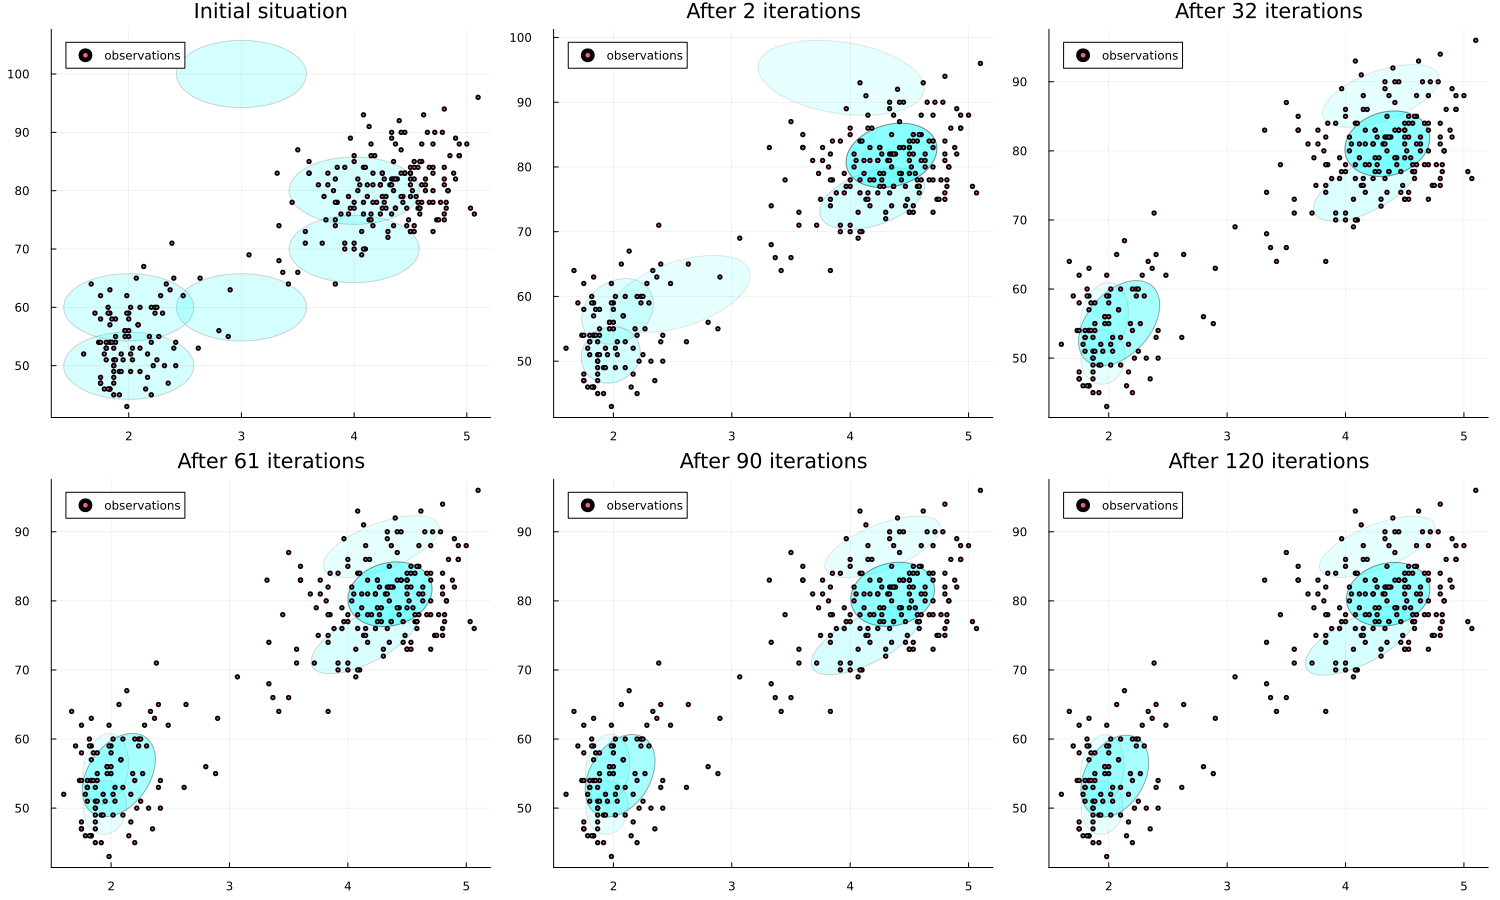

In [6]:
using DataFrames, CSV, LinearAlgebra, PDMats, SpecialFunctions

include("scripts/gmm_plot.jl") # Holds plotting function 
old_faithful = CSV.read("datasets/old_faithful.csv",DataFrame);
X = convert(Matrix{Float64}, [old_faithful[!,1] old_faithful[!,2]]');#data matrix
N = size(X, 2) #number of observations
K = 6

function sufficientStatistics(X,r,k::Int) #function to compute sufficient statistics
    N_k = sum(r[k,:])
    hat_x_k = sum([r[k,n]*X[:,n] for n in 1:N]) ./ N_k
    S_k = sum([r[k,n]*(X[:,n]-hat_x_k)*(X[:,n]-hat_x_k)' for n in 1:N]) ./ N_k
    return N_k, hat_x_k, S_k
end

function updateMeanPrecisionPi(m_0,β_0,W_0,ν_0,α_0,r) #variational maximisation function
    m = Array{Float64}(undef,2,K) #mean of the clusters 
    β = Array{Float64}(undef,K) #precision scaling for Gausian distribution
    W = Array{Float64}(undef,2,2,K) #precision prior for Wishart distributions
    ν = Array{Float64}(undef,K) #degrees of freedom parameter for Wishart distribution
    α = Array{Float64}(undef,K) #Dirichlet distribution parameter 
    for k=1:K
        sst = sufficientStatistics(X,r,k)
        α[k] = α_0[k] + sst[1]; β[k] = β_0[k] + sst[1]; ν[k] = ν_0[k] .+ sst[1]
        m[:,k] = (1/β[k])*(β_0[k].*m_0[:,k] + sst[1].*sst[2])
        W[:,:,k] = inv(inv(W_0[:,:,k])+sst[3]*sst[1] + ((β_0[k]*sst[1])/(β_0[k]+sst[1])).*(sst[2]-m_0[:,k])*(sst[2]-m_0[:,k])')
    end
    return m,β,W,ν,α
end

function updateR(Λ,m,α,ν,β) #variational expectation function
    r = Array{Float64}(undef,K,N) #responsibilities 
    hat_π = Array{Float64}(undef,K) 
    hat_Λ = Array{Float64}(undef,K)
    for k=1:K
        hat_Λ[k] = 1/2*(2*log(2)+logdet(Λ[:,:,k])+digamma(ν[k]/2)+digamma((ν[k]-1)/2))
        hat_π[k] = exp(digamma(α[k])-digamma(sum(α)))
        for n=1:N
           r[k,n] = hat_π[k]*exp(-hat_Λ[k]-1/β[k] - (ν[k]/2)*(X[:,n]-m[:,k])'*Λ[:,:,k]*(X[:,n]-m[:,k]))
        end
    end
    for n=1:N
        r[:,n] = r[:,n]./ sum(r[:,n]) #normalize to ensure r represents probabilities 
    end
    return r
end

max_iter = 120
#store the inference results in these vectors
ν = fill!(Array{Float64}(undef,K,max_iter),3)
β = fill!(Array{Float64}(undef,K,max_iter),1.0)
α = fill!(Array{Float64}(undef,K,max_iter),0.01)
R = Array{Float64}(undef,K,N,max_iter)
M = Array{Float64}(undef,2,K,max_iter)
Λ = Array{Float64}(undef,2,2,K,max_iter)
clusters_vb = Array{Distribution}(undef,K,max_iter) #clusters to be plotted
#initialize prior distribution parameters
M[:,:,1] = [[3.0; 60.0];[4.0; 70.0];[2.0; 50.0];[2.0; 60.0];[3.0; 100.0];[4.0; 80.0]]
for k=1:K
    Λ[:,:,k,1] = [1.0 0;0 0.01]
    R[k,:,1] = 1/(K)*ones(N)
    clusters_vb[k,1] = MvNormal(M[:,k,1],PDMats.PDMat(convert(Matrix,Hermitian(inv(ν[1,1].*Λ[:,:,k,1])))))
end
#variational inference
for i=1:max_iter-1
    #variational expectation 
    R[:,:,i+1] = updateR(Λ[:,:,:,i],M[:,:,i],α[:,i],ν[:,i],β[:,i]) 
    #variational minimisation
    M[:,:,i+1],β[:,i+1],Λ[:,:,:,i+1],ν[:,i+1],α[:,i+1] = updateMeanPrecisionPi(M[:,:,i],β[:,i],Λ[:,:,:,i],ν[:,i],α[:,i],R[:,:,i+1])
    for k=1:K
        clusters_vb[k,i+1] = MvNormal(M[:,k,i+1],PDMats.PDMat(convert(Matrix,Hermitian(inv(ν[k,i+1].*Λ[:,:,k,i+1])))))
    end
end

include("scripts/gmm_plot.jl") # Holds plotting function 
plots = [plotGMM(X, clusters_vb[:,1], R[:,:,1], "Initial situation")]
for i=LinRange(2, 120, 5)
    i = round(Int,i)
    push!(plots, plotGMM(X, clusters_vb[:,i], R[:,:,i], "After $(i) iterations"))
end
plot(plots..., layout=(2,3), size=(1500, 900))


- The generated figure looks much like Figure 10.6 in Bishop. The plots show FEM results for a GMM of $K = 6$ Gaussians applied to the Old Faithful data set. The ellipses denote the one standard-deviation density contours for each of the components, and the color coding of the data points reflects the "soft" class label assignments. Components whose expected mixing coefficient are numerically indistinguishable from zero are not plotted.

### Variational Inference and The Method of Maximum Entropy

- We derived variational inference by substituting a variational posterior $q(z)$ for the Bayesian posterior $p(z|x)$ in the CA decomposition of (negative log) Bayesian evidence for a model. This is clever, but reveals nothing about the foundations of variational inference. Is variational inference any good?

- In [Caticha (2010)](https://arxiv.org/abs/1011.0723) (based on earlier work by [Shore and Johnson (1980)](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/ShoreJohnson-1980-Axiomatic-Derivation-of-the-Principle-of-Maximum-Entropy.pdf)), the **Method of Maximum (Relative) Entropy** is developed for rational updating of priors to posteriors when faced with new information in the form of constraints:

  - Consider prior beliefs $p(z)$ about latent variables $z$. New information in the form of (data, factorization or form) constraints is obtained and we are interested in the "best update" to a posterior $q(z)$.

  - In order to define what "best update" means, Caticha assumed a ranking function $S_p[q]$ that generates a preference score for each candidate posterior $q$ for a given prior $p$. The best update from $p$ to $q$ is then identified as $$q^* = \arg\max_q S_p[q]\,, \quad \text{subject to constraints.} $$ 

  - Similarly to [Cox' method](https://en.wikipedia.org/wiki/Cox%27s_theorem) for deriving Probability Theory from a set of sensical axioms, Caticha then introduced the following axioms, based on a rational principle (the **principle of minimal updating**, see [Caticha 2010](https://arxiv.org/abs/1011.0723)), that the ranking function needs to adhere to: 
    1. *Locality*: local information has local effects.
    2. *Coordinate invariance*: the system of coordinates carries no information. 
    3. *Independence*: When systems are known to be independent, it should not matter whether they are treated separately or jointly. 
  
  - These three criteria **uniquely identify the Relative Entropy** as the proper ranking function: 
$$\begin{align*}
S_p[q] = - \sum_z q(z) \log \frac{q(z)}{p(z)}
\end{align*}$$

  - This procedure is called the Method of Maximum (Relative) Entropy (MRE). Note that constrained Relative Entropy maximization is equivalent to constrained Free Energy minimization! 

- $\Rightarrow$ When information is supplied in the form of constraints on the posterior (including new observations as data constraints), we *should* select the posterior that minimizes the constrained Free Energy. **Constrained FE minimization is the proper method for inference!**

- Bayes rule is the global solution of constrained FEM when all constraints are data constraints. Hence, Bayes rule is a special case of constrained FEM. 

###  Interesting Decompositions of the Free Energy Functional


- <a id="fe-decompositions"></a> In rounding up this lession, we summarize the various interesting decompositions of the FE functional, making use of $p(x,z) = p(z|x)p(x) = p(x|z)p(z)$ 

$$\begin{align*}
\mathrm{F}[q] &\triangleq \sum_z q(z) \log \frac{q(z)}{p(x,z)} \\
&= \underbrace{\sum_z q(z) \log \frac{1}{p(x,z)}}_{\text{energy}} - \underbrace{\sum_z q(z) \log \frac{1}{q(z)}}_{\text{entropy}} \qquad &&\text{(EE)} \\
&= \underbrace{\sum_z q(z) \log \frac{q(z)}{p(z|x)}}_{\text{inference bound}\geq 0} - \underbrace{\log p(x)}_{\text{log-evidence}} \qquad &&\text{(BE)} \\
&= \underbrace{\sum_z q(z)\log\frac{q(z)}{p(z)}}_{\text{complexity}} - \underbrace{\sum_z q(z) \log p(x|z)}_{\text{accuracy}}  \qquad &&\text{(CA)}
\end{align*}$$

- These decompositions are very insightful and we will label them respectively as _energy-entropy_ (EE), _bound-evidence_ (BE), and _complexity-accuracy_ (CA) decompositions. 

- In the [Bayesian Machine Learning](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Bayesian-Machine-Learning.ipynb) lecture, we discussed the CA decomposition of Bayesian model evidence to support the interpretation of evidence as a model performance criterion. Here, we recognize that FE allows a similar CA decomposition: minimizing FE increases data fit and decreases model complexity. Hence, FE is a good model performance criterion.

- The CA decomposition makes use of the prior $p(z)$ and likelihood $p(x|z)$, both of which are selected by the engineer, so the FE can be evaluated with this decomposition!

- The BE decomposition restates what we derived earlier, namely that the FE is an upperbound on the (negative) log-evidence. The bound is the KL-divergence between the variational posterior $q(z)$ and the (perfect) Bayesian posterior $p(z|x)$. Global minimization of FE with only data constraints drives the KL-divergence to zero and results to perfect Bayesian inference.

- The BE decomposition can also be interpreted as problem representation costs (negative log-evidence) plus solution proposal costs (the KL-divergence bound), see the [Intelligent Agent and Active Inference lesson (slide on Problem and Solution costs)](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb#PS-decomposition) for more details.

- The EE decomposition provides a link to the [second law of thermodynamics](https://en.wikipedia.org/wiki/Second_law_of_thermodynamics): Minimizing FE leads to entropy maximization, subject to constraints, where in this case the constraints are imposed by the postulated generative model. 




### Variational Inference in Practice

- For most interesting models of real-world problems, Bayes rule is not tractible. Therefore, the usage of approximate variational Bayesian inference in real-world settings is rising rapidly.

- A toolbox such as [RxInfer](http://rxinfer.ml) makes it possible to specify a complex model and automate the inference process by constrained Free Energy minimization. 

- Note that model specification, even for complex models, usually does not take more than 1 page of code. As a result, you can, in principle, solve very complex problems by automated inference in a complex model with less than 1 page of code. 

- $\Rightarrow$ Compared to writing an application algorithm of, say 40 pages of code, solving problems by automated variational inference is potentially a big deal for the future design of information processing systems. 

## <center><a id="optional-slides">OPTIONAL SLIDES</a></center>

### FE Minimization with Mean-field Factorization Constraints: <a id="CAVI">the CAVI Approach</a> 

- Let's work out FE minimization with additional mean-field constraints (=full factorization) constraints:  $$q(z) = \prod_{j=1}^m q_j(z_j)\,.$$

  - In other words, the posteriors for $z_j$ are all considered independent. This is a strong constraint but leads often to good solutions.
  
- Given the mean-field constraints, it is possible to derive the following expression for the <a id="optimal-solutions">optimal solutions</a> $q_j^*(z_j)$, for $j=1,\ldots,m$: 

\begin{equation*} \tag{B-10.9}
\boxed{
\begin{aligned}
\log q_j^*(z_j) &\propto \mathrm{E}_{q_{-j}^*}\left[ \log p(x,z) \right]  \\
  &= \underbrace{\sum_{z_{-j}} q_{-j}^*(z_{-j}) \underbrace{\log p(x,z)}_{\text{"field"}}}_{\text{"mean field"}} 
\end{aligned}}
\end{equation*}

where we defined $q_{-j}^*(z_{-j}) \triangleq q_1^*(z_1)q_2^*(z_2)\cdots q_{j-1}^*(z_{j-1})q_{j+1}^*(z_{j+1})\cdots q_m^*(z_m)$.
- **Proof** (from [Blei, 2017](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773)): We first rewrite the FE as a function of $q_j(z_j)$ only: 
  $$ F[q_j] = \mathbb{E}_{q_{j}}\left[ \mathbb{E}_{q_{-j}}\left[ \log p(x,z_j,z_{-j})\right]\right] - \mathbb{E}_{q_j}\left[ \log q_j(z_j)\right] + \mathtt{const.}\,,$$
  where the constant holds all terms that do not depend on $z_j$. This expression can be written as 
  $$ F[q_j] = \sum_{z_j} q_j(z_j) \log \frac{q_j(z_j)}{\exp\left( \mathbb{E}_{q_{-j}}\left[ \log p(x,z_j,z_{-j})\right]\right)}$$
  which is a KL-divergence that is minimized by Eq. B-10.9.  (end proof)
  
- This is not yet a full solution to the FE minimization task since the solution $q_j^*(z_j)$ depends on expectations that involve other solutions $q_{i\neq j}^*(z_{i \neq j})$, and each of these other solutions $q_{i\neq j}^*(z_{i \neq j})$ depends on an expection that involves $q_j^*(z_j)$. 
- In practice, we solve this chicken-and-egg problem by an iterative approach: we first initialize all $q_j(z_j)$ (for $j=1,\ldots,m$) to an appropriate initial distribution and then cycle through the factors in turn by solving eq.B-10.9 and update $q_{-j}^*(z_{-j})$ with the latest estimates. (See [Blei, 2017](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773), Algorithm 1, p864).  

- This algorithm for approximating Bayesian inference is known **Coordinate Ascent Variational Inference** (CAVI).   

### <a id="EM-Algorithm">FE Minimization by the Expectation-Maximization (EM) Algorithm</a>

- The EM algorithm is a special case of FE minimization that focusses on Maximum-Likelihood estimation for models with latent variables. 
- Consider a model $$p(x,z,\theta)$$ with observations $x = \{x_n\}$, latent variables $z=\{z_n\}$ and parameters $\theta$.

- We can write the following FE functional for this model:
$$\begin{align*}
F[q] =  \sum_z \sum_\theta q(z,\theta) \log \frac{q(z,\theta)}{p(x,z,\theta)} 
\end{align*}$$

- The EM algorithm makes the following simplifying assumptions:
  1. The prior for the parameters is uninformative (uniform). This implies that 
  $$p(x,z,\theta) = p(x,z|\theta) p(\theta) \propto p(x,z|\theta)$$
  2. A factorization constraint $$q(z,\theta) = q(z) q(\theta)$$
  3. The posterior for the parameters is a delta function:
  $$q(\theta) = \delta(\theta - \hat{\theta})$$
 

 
- Basically, these three assumptions turn FE minimization into maximum likelihood estimation for the parameters $\theta$ and the FE simplifies to 
$$\begin{align*}
F[q,\theta] =  \sum_z q(z) \log \frac{q(z)}{p(x,z|\theta)} 
\end{align*}$$

- The EM algorithm minimizes this FE by iterating (iteration counter: $i$) over 

\begin{equation*}
\boxed{
\begin{aligned}
\mathcal{L}^{(i)}(\theta) &= \sum_z \overbrace{p(z|x,\theta^{(i-1)})}^{q^{(i)}(z)}  \log p(x,z|\theta) \quad &&\text{the E-step} \\
\theta^{(i)} &= \arg\max_\theta \mathcal{L}^{(i)}(\theta) &&\text{the M-step}
\end{aligned}}
\end{equation*}

- These choices are optimal for the given FE functional. In order to see this, consider the two decompositions
$$\begin{align*}
F[q,\theta] &= \underbrace{-\sum_z q(z) \log p(x,z|\theta)}_{\text{energy}} - \underbrace{\sum_z q(z) \log \frac{1}{q(z)}}_{\text{entropy}} \qquad &&\text{(EE)}\\
  &= \underbrace{\sum_z q(z) \log \frac{q(z)}{p(z|x,\theta)}}_{\text{divergence}} - \underbrace{\log p(x|\theta)}_{\text{log-likelihood}}  \qquad &&\text{(DE)}
\end{align*}$$

- The DE decomposition shows that the FE is minimized for the choice $q(z) := p(z|x,\theta)$. Also, for this choice, the FE equals the (negative) log-evidence (, which is this case simplifies to the log-likelihood). 

- The EE decomposition shows that the FE is minimized wrt $\theta$ by minimizing the energy term. The energy term is computed in the E-step and optimized in the M-step.
  - Note that in the EM literature, the energy term is often called the _expected complete-data log-likelihood_.)

- In order to execute the EM algorithm, it is assumed that we can analytically execute the E- and M-steps. For a large set of models (including models whose distributions belong to the exponential family of distributions), this is indeed the case and hence the large popularity of the EM algorithm. 

- The EM algorihm imposes rather severe assumptions on the FE (basically approximating Bayesian inference by maximum likelihood estimation). Over the past few years, the rise of Probabilistic Programming languages has dramatically increased the range of models for which the parameters can by estimated autmatically by (approximate) Bayesian inference, so the popularity of EM is slowly waning. (More on this in the Probabilistic Programming lessons). 

- Bishop (2006) works out EM for the GMM in section 9.2.

### Code Example: EM-algorithm for the GMM on the Old-Faithful data set

We'll perform clustering on the data set from the [illustrative example](#illustrative-example) by fitting a GMM consisting of two Gaussians using the EM algorithm. 

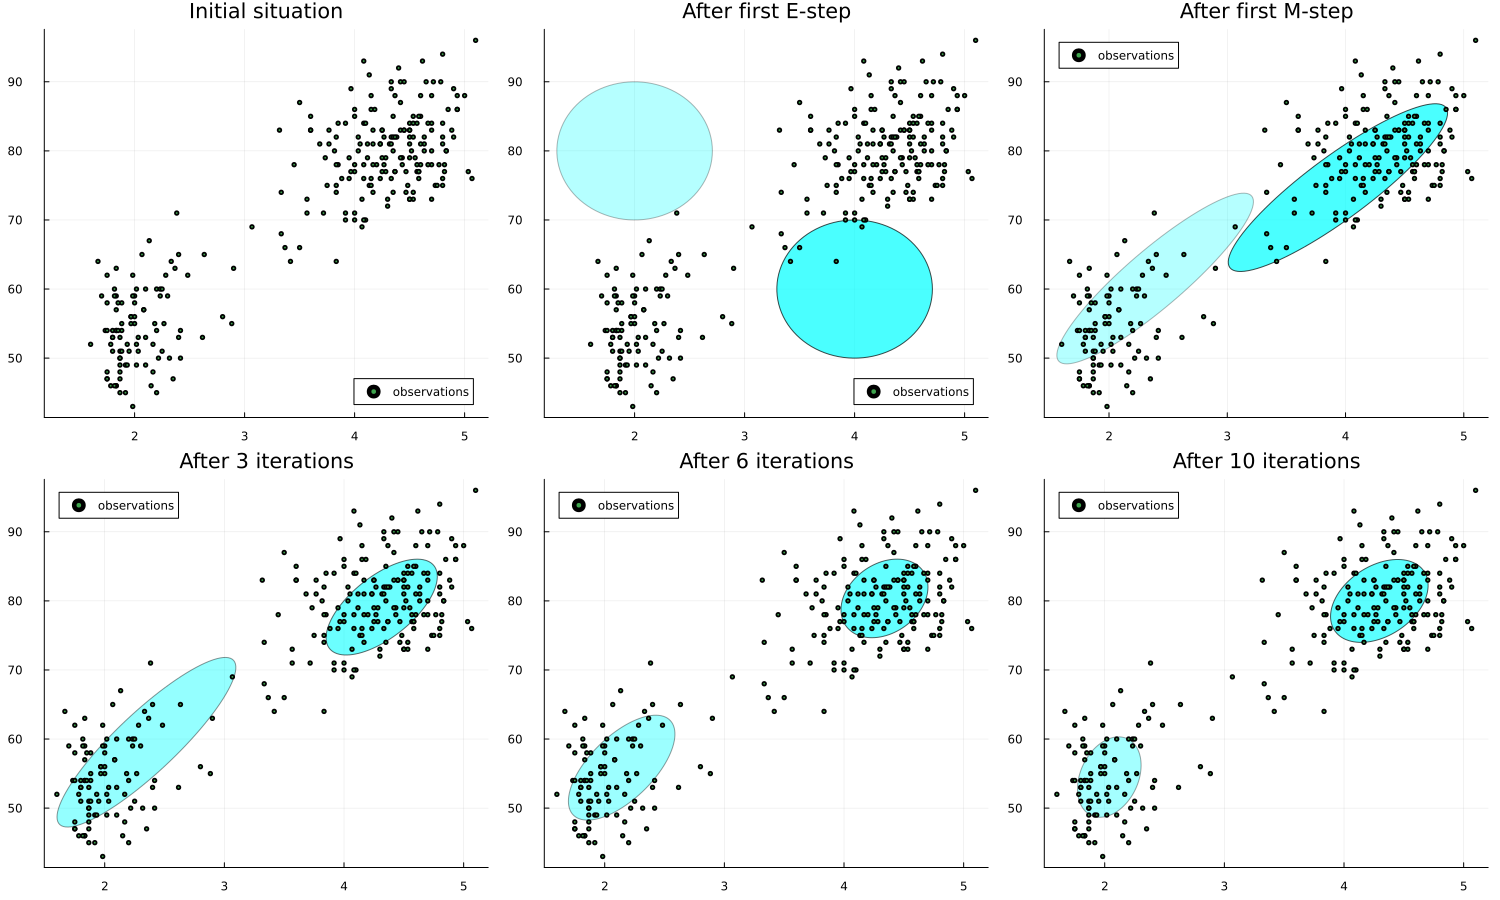

In [7]:
using DataFrames, CSV, LinearAlgebra
include("scripts/gmm_plot.jl") # Holds plotting function 
old_faithful = CSV.read("datasets/old_faithful.csv", DataFrame);

X =  Array(Matrix{Float64}(old_faithful)')
N = size(X, 2)

# Initialize the GMM. We assume 2 clusters.
clusters = [MvNormal([4.;60.], [.5 0;0 10^2]); 
            MvNormal([2.;80.], [.5 0;0 10^2])];
π_hat = [0.5; 0.5]                    # Mixing weights
γ = fill!(Matrix{Float64}(undef,2,N), NaN)  # Responsibilities (row per cluster)

# Define functions for updating the parameters and responsibilities
function updateResponsibilities!(X, clusters, π_hat, γ)
    # Expectation step: update γ
    norm = [pdf(clusters[1], X) pdf(clusters[2], X)] * π_hat
    γ[1,:] = (π_hat[1] * pdf(clusters[1],X) ./ norm)'
    γ[2,:] = 1 .- γ[1,:]
end
function updateParameters!(X, clusters, π_hat, γ)
    # Maximization step: update π_hat and clusters using ML estimation
    m = sum(γ, dims=2)
    π_hat = m / N
    μ_hat = (X * γ') ./ m'
    for k=1:2
        Z = (X .- μ_hat[:,k])
        Σ_k = Symmetric(((Z .* (γ[k,:])') * Z') / m[k])
        clusters[k] = MvNormal(μ_hat[:,k], convert(Matrix, Σ_k))
    end
end

# Execute the algorithm: iteratively update parameters and responsibilities
plots = [plotGMM(X, clusters, γ, "Initial situation")]
updateResponsibilities!(X, clusters, π_hat, γ)
push!(plots, plotGMM(X, clusters, γ, "After first E-step"))
updateParameters!(X, clusters, π_hat, γ)
push!(plots, plotGMM(X, clusters, γ, "After first M-step"))
iter_counter = 1
for i=1:3
    for j=1:i+1
        updateResponsibilities!(X, clusters, π_hat, γ)
        updateParameters!(X, clusters, π_hat, γ)
        iter_counter += 1
    end
    push!(plots, plotGMM(X, clusters, γ, "After $(iter_counter) iterations"))
end
plot(plots..., layout=(2,3), size=(1500, 900))

<!---
Note that you can step through the interactive demo yourself by running [this script](https://github.com/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/scripts/interactive_em_demo.jl) in julia. You can run a script in julia by    
`julia> include("path/to/script-name.jl")`
-->

### Message Passing for Free Energy Minimization

- The Sum-Product (SP) update rule implements perfect Bayesian inference. 
- Sometimes, the SP update rule is not analytically solvable. 
- Fortunately, for many well-known Bayesian approximation methods, a message passing update rule can be created, e.g. [Variational Message Passing](https://en.wikipedia.org/wiki/Variational_message_passing) (VMP) for variational inference. 
- In general, all of these message passing algorithms can be interpreted as minimization of a constrained free energy (e.g., see [Senoz et al. (2021)](https://www.mdpi.com/1099-4300/23/7/807), and hence these message passing schemes comply with [Caticha's Method of Maximum Relative Entropy](https://arxiv.org/abs/1011.0723), which, as discussed in the [variational Bayes lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Latent-Variable-Models-and-VB.ipynb) is the proper way for updating beliefs. 
- Different message passing updates rules can be combined to get a hybrid inference method in one model. 

### The Local Free Energy in a Factor Graph 

- Consider an edge $x_j$ in a Forney-style factor graph for a generative model $p(x) = p(x_1,x_2,\ldots,x_N)$.



- Assume that the graph structure (factorization) is specified by
$$
p(x) = \prod_{a=1}^M p_a(x_a)
$$
where $a$ is a set of indices.
- Also, we assume a mean-field approximation for the posterior:
$$
q(x) = \prod_{i=1}^N q_i(x_i)
$$
and consequently a corresponding free energy functional  
$$\begin{align*}
F[q] &= \sum_x q(x) \log \frac{q(x)}{p(x)} \\
  &= \sum_i \sum_{x_i} \left(\prod_{i=1}^N q_i(x_i)\right) \log \frac{\prod_{i=1}^N q_i(x_i)}{\prod_{a=1}^M p_a(x_a)}
\end{align*}$$

- With these assumptions, it can be shown that the FE evaluates to (exercise)
$$
F[q] = \sum_{a=1}^M \underbrace{\sum_{x_a} \left( \prod_{j\in N(a)} q_j(x_j)\cdot \left(-\log p_a(x_a)\right) \right) }_{\text{node energy }U[p_a]} - \sum_{i=1}^N \underbrace{\sum_{x_i} q_i(x_i) \log \frac{1}{q_i(x_i)}}_{\text{edge entropy }H[q_i]}
$$

- In words, the FE decomposes into a sum of (expected) energies for the nodes minus the entropies on the edges. 
 

### Variational Message Passing

- Let us now consider the local free energy that is associated with edge corresponding to $x_j$. 
  
  <p style="text-align:center;"><img src="./figures/VMP-two-nodes.png" width="600"></p>
  
  
- Apparently (see previous slide), there are three contributions to the free energy for $x_j$:
    - one entropy term for the edge $x_j$
    - two energy terms: one for each node that attaches to $x_j$ (in the figure: nodes $p_a$ and $p_b$)
    
- The local free energy for $x_j$ can be written as (exercise)
  $$
  F[q_j] \propto \sum_{x_j} q(x_j) \log \frac{q_j(x_j)}{\nu_a(x_j)\cdot \nu_b(x_j)}
  $$
  where
  $$\begin{align*} 
  \nu_a(x_j) &\propto \exp\left( \mathbb{E}_{q_{k}}\left[ \log p_a(x_a)\right]\right) \\
  \nu_b(x_j) &\propto \exp\left( \mathbb{E}_{q_{l}}\left[ \log p_b(x_b)\right]\right) 
  \end{align*}$$
  and $\mathbb{E}_{q_{k}}\left[\cdot\right]$ is an expectation w.r.t. all $q(x_k)$ with $k \in N(a)\setminus {j}$.
  
- $\nu_a(x_j)$ and $\nu_b(x_j)$  can be locally computed in nodes $a$ and $b$ respectively and can be interpreted as colliding messages over edge $x_j$. 
  
- Local free energy minimization is achieved by setting
  $$
  q_j(x_j) \propto \nu_a(x_j) \cdot \nu_b(x_j)
  $$
  
- Note that message $\nu_a(x_j)$ depends on posterior beliefs over incoming edges ($k$) for node $a$, and in turn, the message from node $a$ towards edge $x_k$ depends on the belief $q_j(x_j)$. I.o.w., direct mutual dependencies exist between posterior beliefs over edges that attach to the same node. 
  
- These considerations lead to the [Variational Message Passing](https://en.wikipedia.org/wiki/Variational_message_passing) procedure, which is an iterative free energy minimization procedure that can be executed completely through locally computable messages.  

- Procedure VMP, see [Dauwels (2007), section 3](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Dauwels-2007-on-variational-message-passing-on-factor-graphs)
  > 1. Initialize all messages $q$ and $ν$, e.g., $q(\cdot) \propto 1$ and $\nu(\cdot) \propto 1$. <br/>
  > 2. Select an edge $z_k$ in the factor graph of $f(z_1,\ldots,z_m)$.<br/>
  > 3. Compute the two messages $\overrightarrow{\nu}(z_k)$ and $\overleftarrow{\nu}(z_k)$ by applying the following generic rule:
  $$
  \overrightarrow{\nu}(y) \propto \exp\left( \mathbb{E}_{q}\left[ \log g(x_1,\dots,x_n,y)\right] \right) 
  $$
  > 4. Compute the marginal $q(z_k)$
  $$
  q(z_k) \propto \overrightarrow{\nu}(z_k) \overleftarrow{\nu}(z_k)
  $$
  and send it to the two nodes connected to the edge $x_k$.<br/>
  > 5. Iterate 2–4 until convergence. 

### The Bethe Free Energy and Belief Propagation

- We showed that, under mean field assumptions, the FE can be decomposed into a sum of local FE contributions for the nodes ($a$) and edges ($i$):
$$
F[q] = \sum_{a=1}^M \underbrace{\sum_{x_a} \left( \prod_{j\in N(a)} q_j(x_j)\cdot \left(-\log p_a(x_a)\right) \right) }_{\text{node energy }U[p_a]} - \sum_{i=1}^N \underbrace{\sum_{x_i} q_i(x_i) \log \frac{1}{q_i(x_i)}}_{\text{edge entropy }H[q_i]}
$$

- The mean field assumption is very strong and may lead to large inference costs ($\mathrm{KL}(q(x),p(x|\text{data}))$). A more relaxed assumption is to allow joint posterior beliefs over the variables that attach to a node. This idea is expressed by the Bethe Free Energy:
$$
F_B[q] = \sum_{a=1}^M \left( \sum_{x_a} q_a(x_a) \log \frac{q_a(x_a)}{p_a(x_a)} \right)  - \sum_{i=1}^N (d_i - 1) \sum_{x_i} q_i(x_i) \log {q_i(x_i)}
$$
where $q_a(x_a)$ is the posterior joint belief over the variables $x_a$ (i.e., the set of variables that attach to node $a$), $q_i(x_i)$ is the posterior marginal belief over the variable $x_i$ and $d_i$ is the number of factor nodes that link to edge $i$. Moreover, $q_a(x_a)$ and $q_i(x_i)$ are constrained to obey the following equalities:
$$
  \sum_{x_a \backslash x_i} q_a(x_a) = q_i(x_i), ~~~ \forall i, \forall a \\
  \sum_{x_i} q_i(x_i) = 1, ~~~ \forall i \\
  \sum_{x_a} q_a(x_a) = 1, ~~~ \forall a \\
$$

- We form the Lagrangian by augmenting the Bethe Free Energy functional with the constraints:
$$
L[q] = F_B[q] + \sum_i\sum_{a \in N(i)} \lambda_{ai}(x_i) \left(q_i(x_i) - \sum_{x_a\backslash x_i} q(x_a) \right) + \sum_{i} \gamma_i \left(  \sum_{x_i}q_i(x_i) - 1\right) + \sum_{a}\gamma_a \left(  \sum_{x_a}q_a(x_a) -1\right)
$$

- The stationary solutions for this Lagrangian are given by
$$
q_a(x_a) = f_a(x_a) \exp\left(\gamma_a -1 + \sum_{i \in N(a)} \lambda_{ai}(x_i)\right) \\ 
q_i(x_i) = \exp\left(1- \gamma_i + \sum_{a \in N(i)} \lambda_{ai}(x_i)\right) ^{\frac{1}{d_i - 1}}
$$
where $N(i)$ denotes the factor nodes that have $x_i$ in their arguments and $N(a)$ denotes the set of variables in the argument of $f_a$.

- Stationary solutions are functions of Lagrange multipliers. This means that Lagrange multipliers need to be determined. Lagrange multipliers can be determined by plugging the stationary solutions back into the constraint specification and solving for the multipliers which ensure that the constraint is satisfied. The first constraint we consider is normalization, which yields the following identification:
$$
\gamma_a = 1 - \log \Bigg(\sum_{x_a}f_a(x_a)\exp\left(\sum_{i \in N(a)}\lambda_{ai}(x_i)\right)\Bigg)\\
\gamma_i = 1 + (d_i-1) \log\Bigg(\sum_{x_i}\exp\left( \frac{1}{d_i-1}\sum_{a \in N(i)} \lambda_{ai}(x_i)\right)\Bigg).
$$

- The functional form of the Lagrange multipliers that corresponds to the normalization constraint enforces us to obtain the Lagrange multipliers that correspond to the marginalization constraint. To do so we solve for 
$$ \sum_{x_a \backslash x_i} f_a(x_a) \exp\left(\sum_{i \in N(a)} \lambda_{ai}(x_i)\right) = \exp\left(\sum_{a \in N(i)} \lambda_{ai}(x_i)\right) ^{\frac{1}{d_i - 1}} \\ \exp\left(\lambda_{ai}(x_i)\right)\sum_{x_a \backslash x_i} f_a(x_a) \exp\Bigg(\sum_{\substack{{j \in N(a)} \\ j \neq i}}\lambda_{aj}(x_j)\Bigg) = \exp\left(\sum_{a \in N(i)} \lambda_{ai}(x_i)\right) ^{\frac{1}{d_i - 1}}\\ \exp\left(\lambda_{ai}(x_i) + \lambda_{ia}(x_i)\right) = \exp\left(\sum_{a \in N(i)} \lambda_{ai}(x_i)\right) ^{\frac{1}{d_i - 1}}\,, $$ 
where we defined an auxilary function
$$
\exp(\lambda_{ia}(x_i)) \triangleq \sum_{x_a \backslash x_i} f_a(x_a) \exp\Bigg(\sum_{\substack{{j \in N(a)} \\ j \neq i}}\lambda_{aj}(x_j)\Bigg) \,.
$$
This definition is valid since it can be inverted by the relation
$$
\lambda_{ia}(x_i) = \frac{2-d_i}{d_i - 1}\lambda_{ai}(x_i) + \frac{1}{d_i -1}\sum_{\substack{c \in N(i)\\c \neq a}}\lambda_{ci}(x_i)
$$

- In general it is not possible to solve for the Lagrange multipliers analytically and we resort to iteratively obtaining the solutions. This leads to the **Belief Propagation algorithm** where the exponentiated Lagrange multipliers (messages) are updated iteratively via 
$$ \mu_{ia}^{(k+1)}(x_i) = \sum_{x_a \backslash x_i} f_a(x_a) \prod_{\substack{{j \in N(a)} \\ j \neq i}}\mu^{(k)}_{aj}(x_j) \\ \mu_{ai}^{(k)}(x_i) = \prod_{\substack{c \in N(i) \\ c \neq a}}\mu^{(k)}_{ic}(x_i)\,, $$ 
where $k$ denotes iteration number and the messages are defined as
$$
\mu_{ia}(x_i) \triangleq \exp(\lambda_{ia}(x_i))\\
\mu_{ai}(x_i) \triangleq \exp(\lambda_{ai}(x_i))\,.
$$

- For a more complete overview of message passing as Bethe Free Energy minimization, see [Senoz et al. (2021)](https://www.mdpi.com/1099-4300/23/7/807).

In [8]:
open("../../styles/aipstyle.html") do f
    display("text/html", read(f, String))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->